# Stacking Test-Sklearn, XGBoost, CatBoost, LightGBM

## 라이브러리

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import skew
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from math import sqrt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import gc

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

# 하이퍼파라미터 설정
NFOLDS = 3
SEED = 0

[변경 사항]    
원본 코드가 옛날 코드라 바뀐 부분이 있음    
`from sklearn.cross_validation import KFold`   
-> `from sklearn.model_selection import KFold`   
이렇게 바뀜

## 데이터 
캐글 내 Home Credit Default Risk 데이터로 각 파일이 의미하는 바는 다음과 같음.
- application : 대출 신청 시 작성한 내용.
- Previous application : 과거 대출 기록.
- bureau : 개인신용평가기관에 기록된 신청자의 과거 타금융기관과 신용거래 내역(국내의 NICE / KCB).
- application_train.csv : 학습 메인 테이블.
- application_test.csv : 테스트 메인 테이블.
- bureau.csv : 신용평가기관에서 제공한 신용도 정보.
- bureau_balance.csv : 이전 신용거래 월 잔액 정보.
- POS_CASH_balance.csv : 신용 거래 정보.
- credit_card_balance.csv : 신용카드 월 잔액 정보.
- previous_application.csv : 이전 가계신용대출 정보.
- installments_payments.csv : 대출 상환 내역 정보.
- HomeCredit_columns_description.csv : 파일의 열에 대한 정보.

In [3]:
data = pd.read_csv('/kaggle/input/home-credit-default-risk/application_train.csv')
test = pd.read_csv('/kaggle/input/home-credit-default-risk/application_test.csv')
prev = pd.read_csv('/kaggle/input/home-credit-default-risk/previous_application.csv')

In [4]:
# Train 데이터 확인
data.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Test 데이터 확인
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### 데이터 전처리
`pd.factorize()` -> 문자열 카테고리를 정수로 인코딩해주는 함수

In [6]:
# 데이터에서 범주형(categorical) 변수만 뽑기
categorical_feats = [
    f for f in data.columns if data[f].dtype=='object'
]

# 범주형 변수를 숫자로 인코딩하기 = label encoding
for f_ in categorical_feats:
    # indexer 안에는 카테고리 -> 숫자 매핑 정보 있음
    data[f_], indexer = pd.factorize(data[f_])
    test[f_] = indexer.get_indexer(test[f_])

gc.enable() #메모리 절약

# 학습을 위한 타켓값 만들기
y_train = data['TARGET']
del data['TARGET']


## previous_application 인코딩도 마찬가지의 방법으로 
prev_cat_features = [
    f_ for f_ in prev.columns if prev[f_].dtype == 'object'
]

for f_ in prev_cat_features:
    prev[f_], _ = pd.factorize(prev[f_])

## previous_application은 인코딩만 하는게 아니라 이걸 통해 평균 요약 테이블 만듦
avg_prev = prev.groupby('SK_ID_CURR').mean()
cnt_prev = prev[['SK_ID_CURR', 'SK_ID_PREV']].groupby('SK_ID_CURR').count()
avg_prev['nb_app'] = cnt_prev['SK_ID_PREV']
del avg_prev['SK_ID_PREV']

근데 보면 원작성자가 
```
###################################
# PLEASE DON'T DO THIS AT HOME LOL
# Averaging factorized categorical features defeats my own reasoning
###################################
```
이렇게 경고를 적은걸 볼 수 있는데 이는 우리가 인코딩한 범주 간의 관계는 숫자 간의 관계로 해석될 수 없음에도 mean을 하면서 이런 오류가 생길 수 있기 때문임. => 원래는 이렇게 categorical을 숫자로 바꿔서 평균내면 안 됌.    
즉, 대충 "초보자면 따라하지마라" 이런 의미.   
그래서 GPT(진심 만능임)한테 그럼에도 왜 쓰냐고 물어보니까
- Home Credit 대회는 데이터가 매우 크고 복잡함 
- Tree 모델(Boosting, RF, ET)이 숫자를 선형적 관계로 보지 않음
- 캐글용 트릭
    -  높은 차원의 one-hot을 만들면 느림
    -  target encoding은 leakage 위험
    -  factorize+aggregation은 빠르고 간단하면서도 효과 있음            

이런 이유로 쓸 수도 있다고 한다

In [7]:
# 메인 train/test에 집계 피처 조인
# 각 행(고객)에 대해, 방금 만든 avg_prev 피처들을 left join으로 붙임
# 과거 대출 기록이 없는 고객은 NaN이 생기는데 전부 0으로 채움
x_train = data.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')
x_test = test.merge(right=avg_prev.reset_index(), how='left', on='SK_ID_CURR')

x_train = x_train.fillna(0)
x_test= x_test.fillna(0)

In [8]:
# 학습/예측에 쓸 컬럼 정리
ntrain = x_train.shape[0]
ntest = x_test.shape[0]

excluded_feats = ['SK_ID_CURR'] # ID 컬럼이라 학습에서 제외
features = [f_ for f_ in x_train.columns if f_ not in excluded_feats]

x_train = x_train[features]
x_test = x_test[features]

## 모델

In [9]:
# KFold 정의
kf = KFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)

### Wrapper 정의 
각 모델을 같은 인터페이스로 감싸는 Wrapper 정의   
-> 그래야 Stacking OOF 루프 코드가 단순해짐
| 모델                      | 학습 함수         | 예측 함수              | seed 설정 방식                              |
| ----------------------- | ------------- | ------------------ | --------------------------------------- |
| XGBoost 원래 API          | `xgb.train()` | `predict(DMatrix)` | `param['seed']`                         |
| CatBoost                | `fit()`       | `predict_proba()`  | `random_seed`                           |
| LightGBM sklearn API    | `fit()`       | `predict_proba()`  | `feature_fraction_seed`, `bagging_seed` |
| ExtraTrees/RandomForest | `fit()`       | `predict_proba()`  | `random_state`                          |


+++ 추가적으로 몰랐던 부분    
2진 분류일 때 `predict_proba()`의 반환값은 [클래스0 확률, 클래스1 확률]으로 2D 배열임    
`predict_proba(x)[:,1]`은 모든 행에서 두 번째 열만 가져와라는 의미 = positive class(= 1번 클래스)의 예측 확률만 뽑음

In [10]:
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

In [11]:
class CatboostWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_seed'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self,x):
        return self.clf.predict_proba(x)[:,-1]

In [12]:
class LightGBMWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['feature_fraction_seed']=seed
        params['bagging_seed']=seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:, -1]

In [13]:
class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param=params
        self.param['seed']=seed
        self.nrounds=params.pop('nrounds',250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=y_train)
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return self.gbdt.predict(xgb.DMatrix(x))

### Out-of-Fold 예측 모델

모델 학습 단계
| 단계                          | 코드                                          | 의미                        |
| --------------------------- | ------------------------------------------- | ------------------------- |
| **Base Learning (Level-1)** | `get_oof(xg)`, `get_oof(et)` 등              | 여러 모델이 개별적으로 OoF 예측 생성    |
| **Meta Feature 생성**         | `np.concatenate(...)`                       | Base 모델들의 예측을 feature로 결합 |
| **Meta Learning (Level-2)** | `logistic_regression.fit(x_train, y_train)` | 메타 모델이 Base 예측을 입력으로 학습   |

#### **stacking(스태킹)** 이란?  
https://wikidocs.net/237773
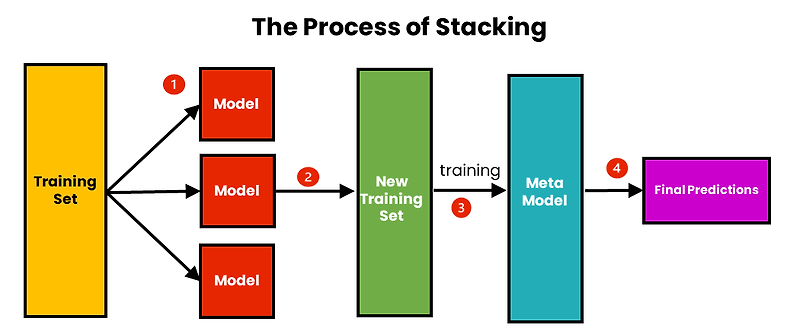
+ 스태킹(stacking)은 여러 개의 기계 학습 모델을 통합하여 예측 정확도를 높이는 앙상블 학습 방법 중 하나
+ 기본 모델(base models)의 예측 결과를 새로운 메타 모델(meta model)의 입력으로 사용하여 최종 예측을 수행  

스태킹은 일반적으로 두 가지 주요 단계로 구성
1. 다양한 기본 모델들이 각각의 데이터 세트에 대해 독립적으로 학습되며, 이 모델들은 각기 다른 머신 러닝 알고리즘을 사용할 수 있음   
2. 이러한 기본 모델들의 예측을 입력으로 사용하여 메타 모델이 학습. 이 메타 모델은 보통 로지스틱 회귀나 다른 간단한 머신 러닝 모델이 사용되며, 기본 모델들의 예측을 종합해 최종적인 예측을 수행.

In [14]:
def get_oof(clf):
    oof_train=np.zeros((ntrain,))
    oof_test=np.zeros((ntest,))
    oof_test_skf=np.empty((NFOLDS, ntest))

    # kf.split(x_train)은 (train_idx, valid_idx) 쌍을 fold 개수만큼 생성
    for i, (train_idx, test_idx) in enumerate(kf.split(x_train)):
        x_tr=x_train.loc[train_idx]
        y_tr=y_train.loc[train_idx]
        x_te=x_train.loc[test_idx]

        # 각 fold마다 새로운 모델이 학습됨
        # OOF 예측은 한 번도 모델이 보지 않은 데이터에 대한 예측
        clf.train(x_tr, y_tr)

        oof_train[test_idx]=clf.predict(x_te)
        oof_test_skf[i, :]=clf.predict(x_test)

    # test 예측 평균내기
    oof_test[:]=oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)


In [15]:
# 각 모델들의 파라미터 
et_params = {
    'n_jobs': 16,
    'n_estimators': 200,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

rf_params = {
    'n_jobs': 16,
    'n_estimators': 200,
    'max_features': 0.2,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'binary:logistic',
    'max_depth': 4,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'nrounds': 200
}

catboost_params = {
    'iterations': 200,
    'learning_rate': 0.5,
    'depth': 3,
    'l2_leaf_reg': 40,
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.7,
    'scale_pos_weight': 5,
    'eval_metric': 'AUC',
    'od_type': 'Iter',
    'allow_writing_files': False
}

lightgbm_params = {
    'n_estimators':200,
    'learning_rate':0.1,
    'num_leaves':123,
    'colsample_bytree':0.8,
    'subsample':0.9,
    'max_depth':15,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'min_split_gain':0.01,
    'min_child_weight':2    
}

In [16]:
# 각 모델의 Wrapper 인스턴스 생성
xg = XgbWrapper(seed=SEED, params=xgb_params)
et = SklearnWrapper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
rf = SklearnWrapper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
cb = CatboostWrapper(clf= CatBoostClassifier, seed = SEED, params=catboost_params)
lg = LightGBMWrapper(clf = LGBMClassifier, seed = SEED, params = lightgbm_params)

In [17]:
# Base Learning
# 각 모델의 OOF 예측 생성 + Cross-Validation 점수
xg_oof_train, xg_oof_test = get_oof(xg)
et_oof_train, et_oof_test = get_oof(et)
rf_oof_train, rf_oof_test = get_oof(rf)
cb_oof_train, cb_oof_test = get_oof(cb)
lg_oof_train, lg_oof_test = get_oof(lg)

print("XG-CV: {}".format(sqrt(mean_squared_error(y_train, xg_oof_train))))
print("ET-CV: {}".format(sqrt(mean_squared_error(y_train, et_oof_train))))
print("RF-CV: {}".format(sqrt(mean_squared_error(y_train, rf_oof_train))))
print("CB-CV: {}".format(sqrt(mean_squared_error(y_train, cb_oof_train))))
print("LG-CV: {}".format(sqrt(mean_squared_error(y_train, lg_oof_train))))

0:	total: 95.1ms	remaining: 18.9s
1:	total: 132ms	remaining: 13.1s
2:	total: 162ms	remaining: 10.6s
3:	total: 196ms	remaining: 9.62s
4:	total: 231ms	remaining: 9s
5:	total: 263ms	remaining: 8.49s
6:	total: 296ms	remaining: 8.15s
7:	total: 326ms	remaining: 7.83s
8:	total: 360ms	remaining: 7.63s
9:	total: 395ms	remaining: 7.5s
10:	total: 425ms	remaining: 7.31s
11:	total: 460ms	remaining: 7.21s
12:	total: 496ms	remaining: 7.13s
13:	total: 531ms	remaining: 7.06s
14:	total: 567ms	remaining: 6.99s
15:	total: 598ms	remaining: 6.88s
16:	total: 627ms	remaining: 6.75s
17:	total: 658ms	remaining: 6.65s
18:	total: 689ms	remaining: 6.56s
19:	total: 717ms	remaining: 6.46s
20:	total: 747ms	remaining: 6.37s
21:	total: 779ms	remaining: 6.3s
22:	total: 814ms	remaining: 6.27s
23:	total: 852ms	remaining: 6.24s
24:	total: 884ms	remaining: 6.19s
25:	total: 917ms	remaining: 6.13s
26:	total: 951ms	remaining: 6.09s
27:	total: 984ms	remaining: 6.05s
28:	total: 1.01s	remaining: 5.98s
29:	total: 1.04s	remaining: 

In [18]:
# meta feature 구성
# 코드에는 LightGBM은 정의했지만 여기서는 왜 안 쓰지?
x_train = np.concatenate((xg_oof_train, et_oof_train, rf_oof_train, cb_oof_train), axis=1)
x_test = np.concatenate((xg_oof_test, et_oof_test, rf_oof_test, cb_oof_test), axis=1)

print("{},{}".format(x_train.shape, x_test.shape))

(307511, 4),(48744, 4)


이렇게 만들어진 feature을 선형 모델로 학습   
```
final_pred =    
w1 * xgb_pred + w2 * et_pred + w3 * rf_pred + w4 * cb_pred + bias
```


In [19]:
# Meta Learning
# 메타 모델(Logistic Regression) 학습 & 최종 예측
logistic_regression = LogisticRegression()
logistic_regression.fit(x_train,y_train)

test['TARGET'] = logistic_regression.predict_proba(x_test)[:,1]

In [20]:
# 제출 파일 생성
test[['SK_ID_CURR', 'TARGET']].to_csv('first_submission.csv', index=False, float_format='%.8f')

In [22]:
#### 추가 실험
#### LightGBM 추가
x_train_exp = np.concatenate((xg_oof_train, et_oof_train, rf_oof_train, cb_oof_train, lg_oof_train), axis=1)
x_test_exp = np.concatenate((xg_oof_test, et_oof_test, rf_oof_test, cb_oof_test, lg_oof_test), axis=1)

print("{},{}".format(x_train_exp.shape, x_test_exp.shape))

# 메타 모델(Logistic Regression) 학습 & 최종 예측
logistic_regression = LogisticRegression()
logistic_regression.fit(x_train_exp,y_train)

test['TARGET'] = logistic_regression.predict_proba(x_test_exp)[:,1]

# 제출 파일 생성
test[['SK_ID_CURR', 'TARGET']].to_csv('second_submission.csv', index=False, float_format='%.8f')

(307511, 5),(48744, 5)


LightGBM가지 결합한게 조금 더 높게 나옴.
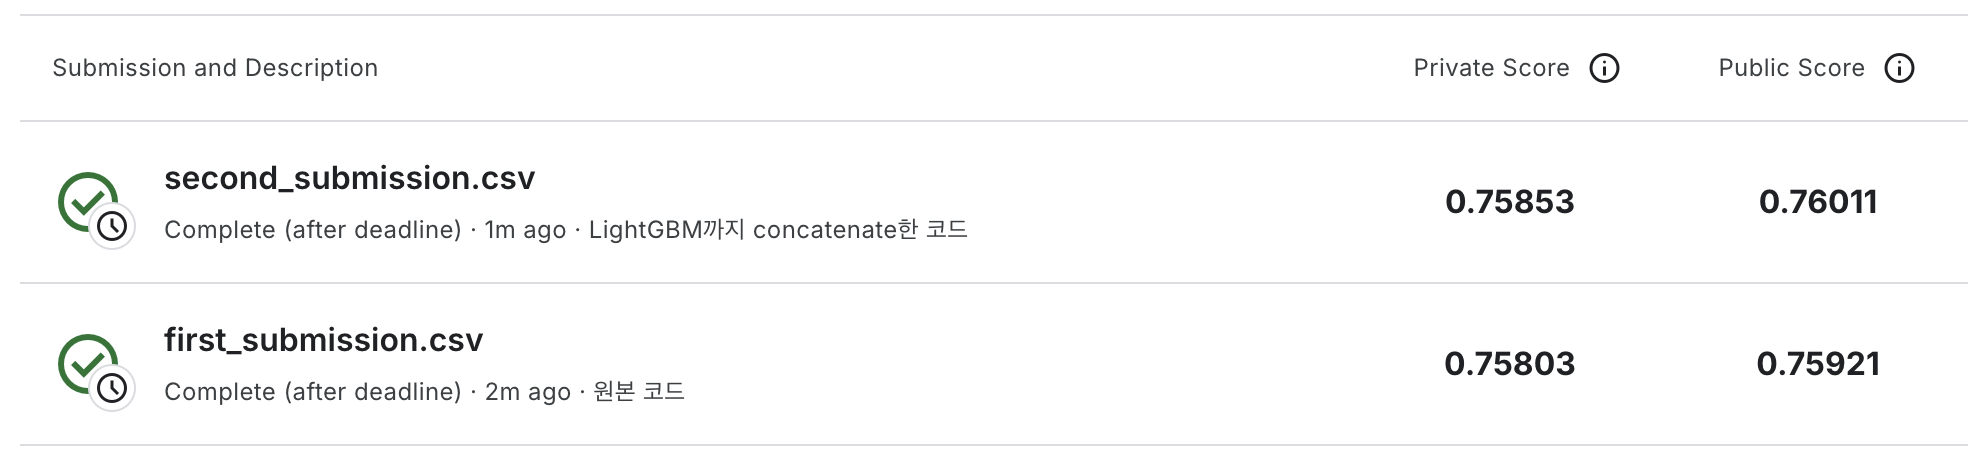